# 任意内容、任意风格的实时图像风格化迁移算法——Arbitrary image stylization

风格迁移（style transfer）即将一张图的风格迁移到另一张图像上，生成同时具有前者风格和后者内容的新图像。早期的风格迁移模型仅支持单风格、或有限风格的迁移，而支持任意风格迁移的模型往往在时效性上有所欠缺，2017年，Golnaz Ghiasi提出了能够对任意内容/风格图像进行实时迁移的arbitrary neural artistic stylization network，兼顾了风格迁移的灵活性与实时性两点需求。

## 模型简介

Arbitrary image stylization进行风格迁移的基本原理是首先通过风格预测模型得到风格向量，再将风格向量传输给风格转换模型，在风格转换模型对内容图像进行归一化的过程中，使用风格向量中指定的参数，即可得到风格化的图像。其中风格预测模型采用Inception-v3结构，而风格转换模型由若干个降采样和上采样层连接而成。训练过程中，将输入的风格图像、内容图像以及得到的风格化的图像都输入VGG网络中，VGG网络较深层的特征中包含了更多的语义信息，因此用来计算内容损失，较浅层的特征中则包含了更多的纹理信息，可用来计算风格损失。

![network](./images/network.png)

## 数据下载

本案例使用ImageNet/train作为训练过程中的内容图像数据集，DTD与PNB作为风格图像数据集，由于PBN数据集中没有类别目录，因此将其与DTD类别文件夹放在同一目录下，可自行前往官网进行下载，解压后使文件呈如下目录结构：

```text
# ImageNet dataset
.imagenet/
├── train/  (1000 directories and 1281167 images)
   ├── n04347754/
   │   ├── 000001.jpg
   │   ├── 000002.jpg
   │   └── ....
   └── n04347756/
       ├── 000001.jpg
       ├── 000002.jpg
       └── ....
# DTD(47 directories and 5640 images) and PBN(79433 images)
.images/
├── banded/
│   ├── banded_0002.jpg
│   ├── banded_0004.jpg
│   └── ....
├── blotchy/
│   ├── blotchy_0003.jpg
│   ├── blotchy_0006.jpg
│   └── ....
└── pbn/
    ├── 1.jpg
    ├── 2.jpg
    └── ....
```

## 参数设置

首先通过args对后续实验中将使用到的参数进行初始化，具体参数值可根据实际需要进行调整，这里使用的参数值仅作参考。

In [1]:
import argparse

from mindspore import context

DEFAULT_CONTENT_WEIGHTS = {"vgg_16/conv3": 1}
DEFAULT_STYLE_WEIGHTS = {"vgg_16/conv1": 0.5e-3, "vgg_16/conv2": 0.5e-3,
                         "vgg_16/conv3": 0.5e-3, 'vgg_16/conv4': 0.5e-3}

def parse_args():
    """Parse args."""
    parser = argparse.ArgumentParser(description='arbitrary image stylization train')
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--max_step', type=int, default=100000, help='Number of total steps.')
    parser.add_argument('--content_path', type=str, default='/data0/imagenet2012/train/', help='Path of content image.')
    parser.add_argument('--style_path', type=str, default='/data0/dtd/dtd/images/', help='Path of style image.')
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--num_workers', type=int, default=1)
    parser.add_argument('--size', type=int, default=256, help='Image size for both content and style.')
    parser.add_argument('--content_weights', type=dict, default=DEFAULT_CONTENT_WEIGHTS,
                        help='Weights for content loss.')
    parser.add_argument('--style_weights', type=dict, default=DEFAULT_STYLE_WEIGHTS, help='Weights for style loss.')
    parser.add_argument('--style_prediction_bottleneck', type=int, default=100)
    parser.add_argument('--vgg_ckpt', type=str, default='./ckpt/vgg.ckpt', help='Path of vgg checkpoint.')
    parser.add_argument('--inception_v3_path', type=str, default='./ckpt/inception_v3.ckpt',
                        help='Path of Inception_V3 checkpoint.')
    parser.add_argument('--learning_rate', type=float, default=1e-5)
    parser.add_argument('--output', type=str, default='./result/', help='Directory to save checkpoint.')
    parser.add_argument('--save_checkpoint_step', type=int, default=10000, help='Interval step of saving checkpoint.')
    parser.add_argument('--device_id', type=int, default=5)
    parser.add_argument('--device_target', type=str, default='GPU', choices=['Ascend', 'GPU', 'CPU'])
    parser.add_argument('--parallel', type=int, default=0, help='0 means training on one card while 1 means parallel training.')
    return parser.parse_known_args()[0]

args = parse_args()

context.set_context(device_target=args.device_target, device_id=args.device_id)

## 数据加载

使用定义好的数据集接口，从指定路径下读取数据集。

In [2]:
from src.dataset.ais_dataset import create_dataset

dataset = create_dataset(args)
dataset_size = dataset.get_dataset_size()

## 创建网络

本案例中网络结构由三个主要模块组成，分别是风格预测模块、风格转换模块以及损失计算模块，下文中将依次介绍各模块的具体结构。

### 风格预测

风格预测模块以风格图像作为输入，作用是获取到风格图像对应的风格向量，风格向量以字典的方式进行存储，对应风格转换模块中相应层归一化所使用的参数。首先使用Inception_V3网络对风格图像进行编码，再通过一个卷积层获取到具有若干个通道的特征，对每个需要beta以及gamma值分别采用卷积的方式得到。

In [3]:
from mindspore import nn
from src.model.inception_v3 import InceptionV3

class StylePrediction(nn.Cell):
    def __init__(self, activation_names, activation_depths, style_prediction_bottleneck=100):
        super(StylePrediction, self).__init__()
        self.encoder = InceptionV3(in_channels=3)
        self.bottleneck = nn.SequentialCell([nn.Conv2d(768, style_prediction_bottleneck, kernel_size=1, has_bias=True)])
        self.activation_depths = activation_depths
        self.activation_names = activation_names
        self.beta = nn.CellList()
        self.gamma = nn.CellList()
        self.squeeze = ops.Squeeze((2, 3))
        for i in activation_depths:
            self.beta.append(nn.Conv2d(style_prediction_bottleneck, i, kernel_size=1, has_bias=True))
            self.gamma.append(nn.Conv2d(style_prediction_bottleneck, i, kernel_size=1, has_bias=True))

    def construct(self, x):
        """ Forward process """
        reduce_mean = ops.ReduceMean(keep_dims=True)
        x = self.encoder(x)
        x = reduce_mean(x, (2, 3))
        x = self.bottleneck(x)
        style_params = {}
        for i in range(len(self.activation_depths)):
            beta = self.beta[i](x)
            beta = self.squeeze(beta)
            style_params[self.activation_names[i] + '/beta'] = beta
            gamma = self.gamma[i](x)
            gamma = self.squeeze(gamma)
            style_params[self.activation_names[i] + '/gamma'] = gamma
        return style_params, x

### 风格转换

风格转换模块由若干个降采样层、残差层以及上采样层组成，以内容图像、归一化函数以及归一化参数作为输入，输出风格化的目标图像。风格转换的基本原理则是在残差层以及上采样层的归一化步骤中使用风格预测模块中获取到的参数值。

In [4]:
from src.model.transform import BasicConv2d, Residual, Upsampling

class Transform(nn.Cell):
    def __init__(self, in_channels=3, alpha=1.0):
        super(Transform, self).__init__()
        self.contract = nn.SequentialCell([
            BasicConv2d(in_channels, int(alpha * 32), kernel_size=9, stride=1,
                        normalizer_fn=nn.BatchNorm2d(int(alpha * 32), eps=0.001)),
            BasicConv2d(int(alpha * 32), int(alpha * 64), kernel_size=3, stride=2,
                        normalizer_fn=nn.BatchNorm2d(int(alpha * 64), eps=0.001)),
            BasicConv2d(int(alpha * 64), int(alpha * 128), kernel_size=3, stride=2,
                        normalizer_fn=nn.BatchNorm2d(int(alpha * 128), eps=0.001))
        ])
        self.residual = nn.SequentialCell([
            Residual(int(alpha * 128), 3),
            Residual(int(alpha * 128), 3),
            Residual(int(alpha * 128), 3),
            Residual(int(alpha * 128), 3),
            Residual(int(alpha * 128), 3)
        ])
        self.expand = nn.SequentialCell([
            Upsampling(2, (32, 32), 3, int(alpha * 128), int(alpha * 64)),
            Upsampling(2, (64, 64), 3, int(alpha * 64), int(alpha * 32)),
            Upsampling(1, (128, 128), 9, int(alpha * 32), 3, activation_fn=nn.Sigmoid())
        ])

    def construct(self, x):
        x, normalizer_fn, style_params = x
        out = self.contract((x, None, None, 0))
        x, _, _, _ = out
        x = self.residual((x, normalizer_fn, style_params, 0))
        out = self.expand(x)
        x, _, _, _ = out
        return x

### 归一化

风格迁移的核心过程即在生成图像的过程中使用指定参数的归一化，因此需要自定义归一化操作。

In [5]:
from mindspore import nn, ops

class ConditionalStyleNorm(nn.Cell):
    def __init__(self, style_params=None, activation_fn=None):
        super(ConditionalStyleNorm, self).__init__()
        self.style_params = style_params
        self.moments = nn.Moments(axis=(2, 3), keep_dims=True)
        self.activation_fn = activation_fn
        self.rsqrt = ops.Rsqrt()
        self.cast = ops.Cast()

    def get_style_parameters(self, style_params):
        """Gets style normalization parameters."""
        var = []
        for i in style_params.keys():
            var.append(style_params[i].expand_dims(2).expand_dims(3))
        return var

    def norm(self, x, mean, variance, style_parameters, variance_epsilon, order):
        """ Normalization function with specific parameters. """
        inv = self.rsqrt(variance + variance_epsilon)
        gamma = style_parameters[order*2+1]
        beta = style_parameters[order*2]
        if gamma is not None:
            inv *= gamma
        data1 = self.cast(inv, x.dtype)
        data2 = x * data1
        data3 = mean * inv
        if gamma is not None:
            data4 = beta - data3
        else:
            data4 = -data3
        data5 = data2 + data4
        return data5

    def construct(self, input_):
        x, style_params, order = input_
        mean, variance = self.moments(x)
        style_parameters = self.get_style_parameters(style_params)
        output = self.norm(x, mean, variance, style_parameters, 1e-5, order)
        if self.activation_fn:
            output = self.activation_fn(output)
        return output

### 生成网络

将上述模块结合起来即可构成完整的生成网络。

In [6]:
def style_normalization_activations(pre_name='transformer', post_name='StyleNorm', alpha=1.0):
    """Get names and depths of each layer."""
    scope_names = [
        'residual/residual1/conv1', 'residual/residual1/conv2',
        'residual/residual2/conv1', 'residual/residual2/conv2',
        'residual/residual3/conv1', 'residual/residual3/conv2',
        'residual/residual4/conv1', 'residual/residual4/conv2',
        'residual/residual5/conv1', 'residual/residual5/conv2',
        'expand/conv1/conv', 'expand/conv2/conv', 'expand/conv3/conv'
    ]
    scope_names = ['{}/{}/{}'.format(pre_name, name, post_name) for name in scope_names]
    # 10 convolution layers of 'residual/residual*/conv*' have the same depth.
    depths = [int(alpha * 128)] * 10 + [int(alpha * 64), int(alpha * 32), 3]
    return scope_names, depths

class Ais(nn.Cell):
    def __init__(self, style_prediction_bottleneck=100):
        super(Ais, self).__init__()
        activation_names, activation_depths = style_normalization_activations()
        self.style_predict = StylePrediction(activation_names, activation_depths,
                                             style_prediction_bottleneck=style_prediction_bottleneck)
        self.transform = Transform(3)
        self.norm = ConditionalStyleNorm()

    def construct(self, x):
        content, style = x
        style_params, _ = self.style_predict(style)
        stylized_images = self.transform((content, self.norm, style_params))
        return stylized_images

## 损失函数

与一般的视觉任务不同，风格转换任务在训练时往往缺乏特定的真实值作为参考，因此不能简单地通过与真实值进行比较的方式计算损失，一个比较常见的损失计算方式是比较生成图像与内容图像、风格图像在VGG特征空间的距离，分别计算内容损失和风格损失，并进行加权。
具体公式：

$$
\mathcal{L}_{s}(x, s)=\sum_{i \in \mathcal{S}} \frac{1}{n_{i}}\left\|\mathcal{G}\left[f_{i}(x)\right]-\mathcal{G}\left[f_{i}(s)\right]\right\|_{F}^{2}
$$

$$
\mathcal{L}_{c}(x, c)=\sum_{j \in \mathcal{C}} \frac{1}{n_{j}}\left\|f_{j}(x)-f_{j}(c)\right\|_{2}^{2}
$$

其中$\mathcal{s}$和$\mathcal{c}$分别代表VGG网络的较低层和较高层，$f_{l}(x)$表示第$l$层的激活，$n_l$是第$l$层总的单元数，$\mathcal{G}\left[f_{i}(x)\right]$则表示其对应的Gram矩阵。

In [7]:
import mindspore

from src.model.vgg import VGG

class TotalLoss(nn.Cell):
    def __init__(self, in_channel, content_weights, style_weights):
        super(TotalLoss, self).__init__()
        self.encoder = VGG(in_channel)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.matmul = ops.BatchMatMul(transpose_b=True)
        self.l2_loss = nn.MSELoss()

    def content_loss(self, content_end_points, stylized_end_points, content_weights):
        """Get content distance in representational space."""
        total_content_loss = 0
        content_loss_dict = {}
        reduce_mean = ops.ReduceMean()
        for name, weights in content_weights.items():
            loss = reduce_mean((content_end_points[name] - stylized_end_points[name]) ** 2)
            weighted_loss = weights * loss
            content_loss_dict['content_loss/' + name] = loss
            content_loss_dict['weighted_content_loss/' + name] = weighted_loss
            total_content_loss += weighted_loss
        content_loss_dict['total_content_loss'] = total_content_loss

        return total_content_loss, content_loss_dict

    def style_loss(self, style_end_points, stylized_end_points, style_weights):
        """Get style distance in representational space."""
        reduce_mean = ops.ReduceMean()
        total_style_loss = 0
        style_loss_dict = {}
        for name, weights in style_weights.items():
            loss = reduce_mean(
                (self.get_matrix(stylized_end_points[name]) - self.get_matrix(style_end_points[name])) ** 2
            )
            weighted_loss = weights * loss
            style_loss_dict['style_loss/' + name] = loss
            style_loss_dict['weighted_style_loss/' + name] = weighted_loss
            total_style_loss += weighted_loss
        style_loss_dict['total_style_loss'] = total_style_loss
        return total_style_loss, style_loss_dict

    def get_matrix(self, feature):
        """Computes the Gram matrix for a set of feature maps."""
        batch_size, channels, height, width = feature.shape
        denominator = float(height * width)
        fill = ops.Fill()
        denominator = fill(mindspore.float32, (batch_size, channels, channels), denominator)
        feature_map = feature.reshape((batch_size, channels, height * width))
        matrix = self.matmul(feature_map.astype("float16"), feature_map.astype("float16"))
        div = ops.Div()
        return div(matrix, denominator)

    def construct(self, content, style, stylized):
        content_end_points = self.encoder(content)
        style_end_points = self.encoder(style)
        stylized_end_points = self.encoder(stylized)
        total_content_loss, _ = self.content_loss(content_end_points, stylized_end_points, self.content_weights)
        total_style_loss, _ = self.style_loss(style_end_points, stylized_end_points, self.style_weights)
        loss = total_content_loss + total_style_loss
        return loss

## 训练

由于损失函数的特殊性，需要对WithLossCell类进行自定义，从而实现网络和损失函数的封装。

In [8]:
class WithLossCell(nn.Cell):
    def __init__(self, network, loss_fn):
        super(WithLossCell, self).__init__()
        self.network = network
        self.loss_fn = loss_fn

    def construct(self, content, style):
        stylized = self.network((content, style))
        loss = self.loss_fn(content, style, stylized)
        return loss

执行训练过程前首先对网络模型、损失函数、优化器进行实例化，并加载VGG与Inception_V3的预训练权重。

In [9]:
from mindspore import load_checkpoint, load_param_into_net

# Create model.
network = Ais(args.style_prediction_bottleneck)
loss = TotalLoss(3, args.content_weights, args.style_weights)
load_param_into_net(loss, load_checkpoint(args.vgg_ckpt))
load_param_into_net(network.style_predict.encoder, load_checkpoint(args.inception_v3_path))
net_with_loss = WithLossCell(network, loss)
opt = nn.Adam(network.trainable_params(), learning_rate=args.learning_rate)
train_net = nn.TrainOneStepCell(net_with_loss, opt)

开始逐步执行训练过程，每训练300个step则输出一次平均loss，由于总的训练过程较长，这里只展示部分训练结果，得到示例中的效果大约需要3,000,000次迭代。

In [10]:
from mindspore import save_checkpoint, Tensor

train_net.set_train()
step = 0
loss = 0
for step in range(args.max_step):
    if step % dataset_size == 0:
        dataloader = dataset.create_dict_iterator()
    data = next(dataloader)
    content = Tensor(data['content'])
    style = Tensor(data['style'])
    result = train_net(content, style)
    loss += result
    if step % 300 == 0 and step != 0:
        loss = loss / 300.0
        print(f'Step:{step:6d}/{args.max_step} Loss:{float(loss):10.2f}')
        loss = 0
    if step % args.save_checkpoint_step == 0 and step != 0:
        save_checkpoint(train_net.network.network,
                        f'{args.output}model-{int(step/args.save_checkpoint_step)}.ckpt')
    step = step + 1

[ERROR] CORE(177813,7f5eb9288740,python):2022-08-01-22:01:04.297.661 [mindspore/core/utils/file_utils.cc:254] GetRealPath] Get realpath failed, path[/tmp/ipykernel_177813/994993376.py]


Step:   300/100000 Loss:5683413.00
Step:   600/100000 Loss:4708741.00
Step:   900/100000 Loss:4933982.00
Step:  1200/100000 Loss:4296705.50
Step:  1500/100000 Loss:3931031.00
Step:  1800/100000 Loss:4188073.50
Step:  2100/100000 Loss:3620565.75
Step:  2400/100000 Loss:3783307.50
......
Step: 99300/100000 Loss: 693875.38
Step: 99600/100000 Loss: 705816.88
Step: 99900/100000 Loss: 700427.06


## 推理

使用以下两个图像分别作为风格以及内容输入，可根据需要修改为实际路径，使用以下代码进行推理并展示迁移结果。
<table>
    <tr>
        <td><img src="./images/style/2575.jpg" height="200"></td>
        <td><img src="./images/content/eiffel_tower.jpg" height="200"></td>
    </tr>
</table>

[WARNING] ME(177813:140044810094400,MainProcess):2022-08-02-15:59:23.987.257 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter optimizer.network.style_predict.encoder.model.0.conv.weight's prefix name: optimizer.network., continue to load it to net parameter style_predict.encoder.model.0.conv.weight.
[WARNING] ME(177813:140044810094400,MainProcess):2022-08-02-15:59:23.996.848 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter network.network.style_predict.encoder.model.0.bn.moving_mean's prefix name: network.network., continue to load it to net parameter style_predict.encoder.model.0.bn.moving_mean.


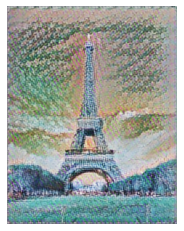

In [11]:
import cv2
import matplotlib.pyplot as plt

def parse_args_test():
    """Parse args."""
    parser = argparse.ArgumentParser(description='arbitrary image stylization infer')
    parser.add_argument('--content_path', type=str, default='./images/content/eiffel_tower.jpg', help='Path of content image.')
    parser.add_argument('--style_path', type=str, default='./images/style/2575.jpg', help='Path of style image.')
    parser.add_argument('--style_prediction_bottleneck', type=int, default=100)
    parser.add_argument('--ckpt_path', type=str, default='./ckpt/Ais.ckpt', help='Path of checkpoint.')
    return parser.parse_known_args()[0]

def get_image(path):
    image = cv2.imread(path)
    image = Tensor(image, mindspore.float32)
    image = image.transpose((2, 0, 1))
    image = image / 255.0
    image = image.expand_dims(axis=0)
    return image

# create the network
args = parse_args_test()
network = Ais(args.style_prediction_bottleneck)
load_param_into_net(network, load_checkpoint(args.ckpt_path))
# load images
content = get_image(args.content_path)
style = get_image(args.style_path)
# predict
stylized = network((content, style))
stylized = stylized.asnumpy()[0].transpose((1, 2, 0))
plt.imshow(stylized)
plt.axis('off')
plt.show()

## 引用

[1] Ghiasi G, Lee H, Kudlur M, et al. Exploring the structure of a real-time, arbitrary neural artistic stylization network[J]. arXiv preprint arXiv:1705.06830, 2017.